# Forest cover type prediction in Roosevelt National Forest

# Feature Selection

This notebook is part of my analysis and development of a ML model to predict cover type in Roosevelt National Forest. It is a Kaggle Competition for novices

Kernell based on a very interesting kernell: https://www.kaggle.com/kwabenantim/forest-cover-feature-engineering

Other recomended kernels: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard


### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Libraries to evaluate the set of features selected
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score


%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# Global parameters
#root folder
root_folder='..\..'
#data_folder='.'
data_folder_name='Datasets/RooseveltForest'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH


In [3]:
train_path

'C:\\Users\\edumu\\Documents\\Datasets\\RooseveltForest'

### Loading the training dataset

In [36]:
# Reading the csv file with the train data
data = pd.read_csv(train_path+'\\train.csv', sep=',', header=0, index_col=0)
test = pd.read_csv(test_path+'\\test.csv', sep=',', header=0, index_col=0)

X_train = data.drop('Cover_Type', axis='columns')
y_train = data['Cover_Type']

In [40]:
print('Train Shape: ',X_train.shape)
print('Test Shape: ',test.shape)

Train Shape:  (15120, 54)
Test Shape:  (565892, 54)


We will use a simple but efficient Random Forest classifier to evaluate the importance of features and score the results and plot a 

In [41]:
# Create a Random Forest model to evaluate feature importance
clf = RandomForestClassifier(n_estimators=125,
                             min_samples_leaf=1,
                             max_depth=None,
                             verbose=0,
                             random_state=0,
                             n_jobs=-1)

Define some helper functions

In [42]:
# Plot the feature importance determined by the classifier clf
def feature_importances(clf, X, y):
    clf = clf.fit(X, y)
    
    importances = pd.DataFrame({'Features': X.columns, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=(14, 4))
    sns.barplot(x='Features', y='Importances', data=importances)
    plt.xticks(rotation='vertical')
    plt.show()

In [43]:
# Calculate the accuracy using a cross validated approach 
def cv_accuracy(clf, X, y):
    scores = cross_val_score(clf, X, y, 
                             cv=5, 
                             scoring='accuracy',
                             verbose=0, 
                             n_jobs=-1)
    
    print('Cross-validation accuracy: {:.3f} {}'.format(np.mean(scores),  
                                                        np.around(scores, 3)))


In [44]:
# Shows the confusion matrix using criss validated predictions
def cv_confusion(clf, X, y):
    prediction = cross_val_predict(clf, X, y, 
                                   cv=5, 
                                   verbose=0, 
                                   n_jobs=-1)
    
    classes = sorted(y.unique().tolist())

    conf_mat = confusion_matrix(y, prediction)
    norm_conf_mat = np.around(conf_mat / conf_mat.sum(axis=1), 2)

    fig = plt.figure(figsize=(14, 8))

    fig.add_subplot(1, 2, 1)
    ax = sns.heatmap(norm_conf_mat, annot=True, cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title='Normalized')


    fig.add_subplot(1, 2, 2)
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title ='Counts')

    #plt.tight_layout()
    plt.show()

In [45]:
# Plot correlations between numerical features
def plot_correlations(X, annot=False):
    numericals = [col for col in X.columns if 
                  'Soil_Type' not in col and 
                  'Wilderness_Area' not in col]

    numericals = sorted(numericals)

    # Place correlations in four bins
    corr = np.around(X[numericals].corr().abs(), 1)
    
    corr_bin = corr.copy()
    corr_bin = corr_bin.where(corr_bin > 0.30, 0.30)

    corr_bin = corr_bin.where((corr_bin <= 0.30) | 
                              (corr_bin > 0.50), 0.50)

    corr_bin = corr_bin.where((corr_bin <= 0.50) | 
                              (corr_bin > 0.70), 0.70)

    corr_bin = corr_bin.where(corr_bin <= 0.70, 1.0)
    
    if annot:
        annot = corr
        
    # Show binned correlation plot
    fig = plt.figure(figsize=(12, 12))
    sns.heatmap(corr_bin, annot=annot, linewidths=1, square=True, 
                cmap='BuPu', cbar_kws={'shrink':0.5})
    plt.title('Feature Correlations')
    plt.show()

In the next cell we can see what features are more relevant to predict the cover type in our initial RF model

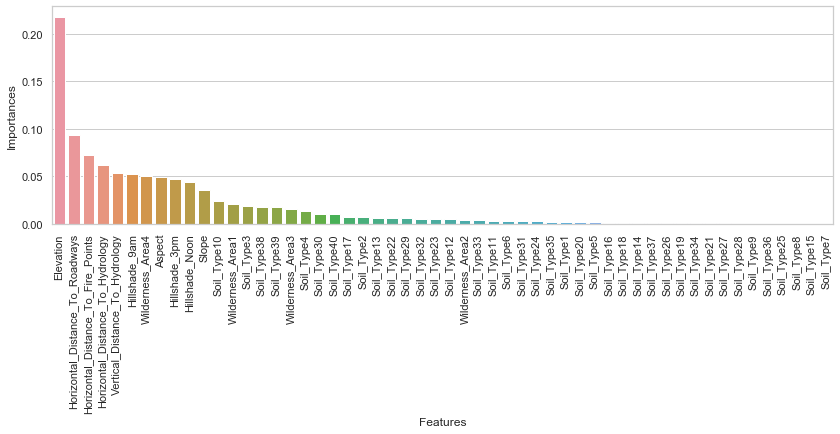

In [46]:
feature_importances(clf, X_train, y_train)

In [47]:
# Calculate the cross-validation accuracy for our RF model
cv_accuracy(clf, X_train, y_train)

Cross-validation accuracy: 0.784 [0.745 0.742 0.771 0.807 0.853]


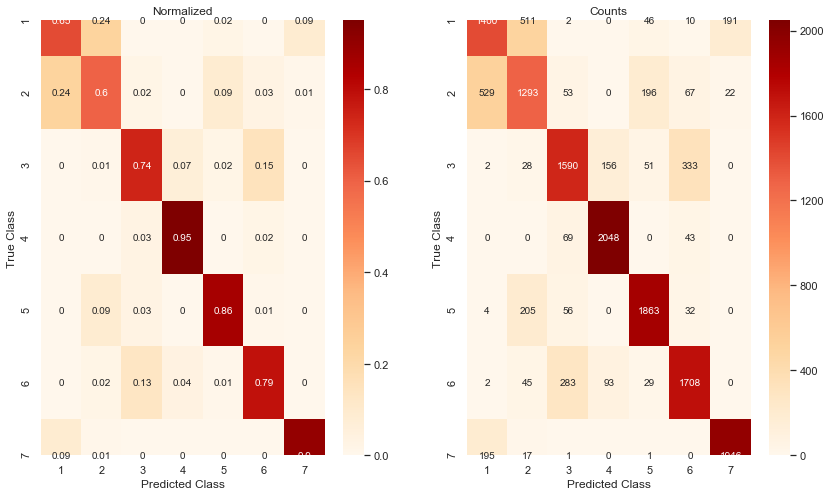

In [48]:
# Calculate the confussion matrix for our RF model
cv_confusion(clf, X_train, y_train)

First, we will create some new features, a feature engineering task, to help us to get better predictions

In [49]:
# This new features has been extracted from some posts and kernell of other competitors
def add_features(X_):
    X = X_.copy()
    
    X['Hydro_Elevation_sum'] = X[['Elevation',
                                  'Vertical_Distance_To_Hydrology']
                                 ].sum(axis='columns')
    
    X['Hydro_Elevation_diff'] = X[['Elevation',
                                   'Vertical_Distance_To_Hydrology']
                                  ].diff(axis='columns').iloc[:, [1]]

    X['Hydro_Euclidean'] = np.sqrt(X['Horizontal_Distance_To_Hydrology']**2 +
                                   X['Vertical_Distance_To_Hydrology']**2)

    X['Hydro_Manhattan'] = (X['Horizontal_Distance_To_Hydrology'] +
                            X['Vertical_Distance_To_Hydrology'].abs())
    
    
    X['Hydro_Distance_sum'] = X[['Horizontal_Distance_To_Hydrology',
                                 'Vertical_Distance_To_Hydrology']
                                ].sum(axis='columns')

    X['Hydro_Distance_diff'] = X[['Horizontal_Distance_To_Hydrology',
                                  'Vertical_Distance_To_Hydrology']
                                 ].diff(axis='columns').iloc[:, [1]]
    
    X['Hydro_Fire_sum'] = X[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Fire_Points']
                            ].sum(axis='columns')

    X['Hydro_Fire_diff'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    X['Hydro_Fire_mean'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].mean(axis='columns')

    X['Hydro_Fire_median'] = X[['Horizontal_Distance_To_Hydrology',
                                'Horizontal_Distance_To_Fire_Points']
                               ].median(axis='columns')
                               
    X['Hydro_Road_sum'] = X[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Roadways']
                            ].sum(axis='columns')

    X['Hydro_Road_diff'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    X['Hydro_Road_mean'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].mean(axis='columns')

    X['Hydro_Road_median'] = X[['Horizontal_Distance_To_Hydrology',
                                'Horizontal_Distance_To_Roadways']
                               ].median(axis='columns')
    
    X['Road_Fire_sum'] = X[['Horizontal_Distance_To_Roadways',
                            'Horizontal_Distance_To_Fire_Points']
                           ].sum(axis='columns')

    X['Road_Fire_diff'] = X[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].diff(axis='columns').iloc[:, [1]].abs()

    X['Road_Fire_mean'] = X[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].mean(axis='columns')

    X['Road_Fire_median'] = X[['Horizontal_Distance_To_Roadways',
                               'Horizontal_Distance_To_Fire_Points']
                              ].median(axis='columns')
    
    X['Hydro_Road_Fire_mean'] = X[['Horizontal_Distance_To_Hydrology',
                                   'Horizontal_Distance_To_Roadways',
                                   'Horizontal_Distance_To_Fire_Points']
                                  ].mean(axis='columns')

    X['Hydro_Road_Fire_median'] = X[['Horizontal_Distance_To_Hydrology',
                                     'Horizontal_Distance_To_Roadways',
                                     'Horizontal_Distance_To_Fire_Points']
                                    ].median(axis='columns')

    X['Hillshade_sum'] = X[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].sum(axis='columns')

    X['Hillshade_mean'] = X[['Hillshade_9am',
                             'Hillshade_Noon',
                             'Hillshade_3pm']
                            ].mean(axis='columns')

    X['Hillshade_median'] = X[['Hillshade_9am',
                               'Hillshade_Noon',
                               'Hillshade_3pm']
                              ].median(axis='columns')

    X['Hillshade_min'] = X[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].min(axis='columns')

    X['Hillshade_max'] = X[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].max(axis='columns')
        
    # Compute Soil_Type number from Soil_Type binary columns
    X['Stoneyness'] = sum(i * X['Soil_Type{}'.format(i)] for i in range(1, 41))
    
    # For all 40 Soil_Types, 1=rubbly, 2=stony, 3=very stony, 4=extremely stony, 0=?
    stoneyness = [4, 3, 1, 1, 1, 2, 0, 0, 3, 1, 
                  1, 2, 1, 0, 0, 0, 0, 3, 0, 0, 
                  0, 4, 0, 4, 4, 3, 4, 4, 4, 4, 
                  4, 4, 4, 4, 1, 4, 4, 4, 4, 4]
    
    # Replace Soil_Type number with "stoneyness" value
    X['Stoneyness'] = X['Stoneyness'].replace(range(1, 41), stoneyness)

    return X

In [50]:
# Add the new features to the dataset
X_train = add_features(X_train)
test = add_features(test)

In [52]:
test.shape,X_train.shape

((565892, 80), (15120, 80))

Now, we repeat the evaluation process on the new group if features including those that result from our feature engineer task.

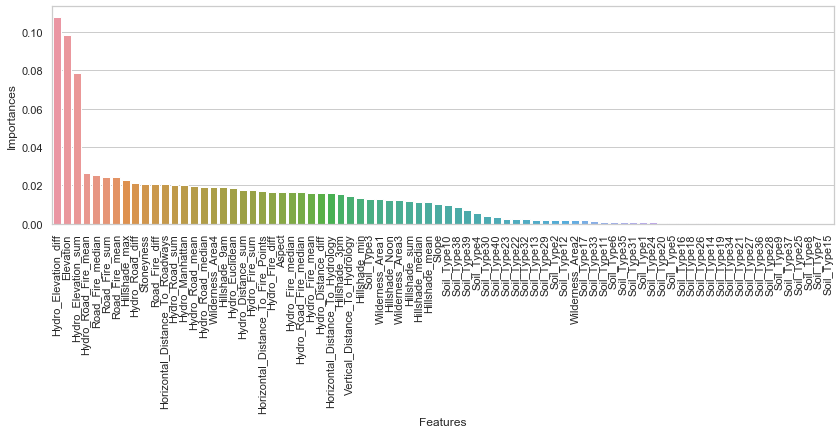

Cross-validation accuracy: 0.806 [0.787 0.779 0.786 0.807 0.87 ]


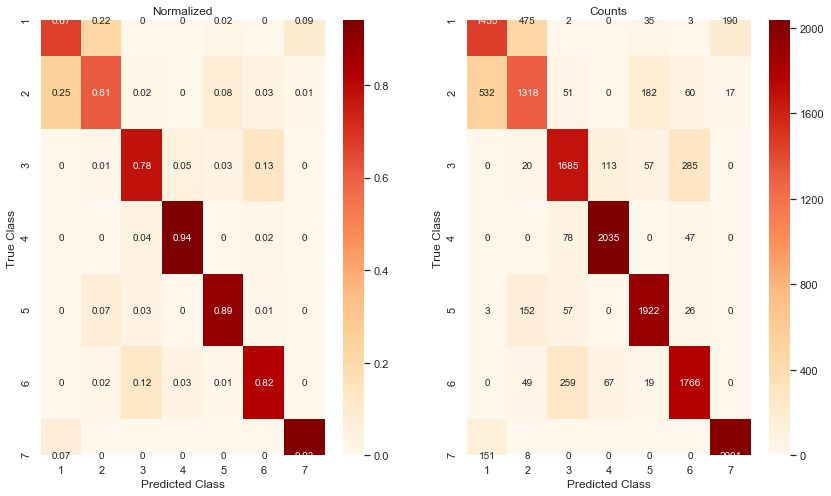

In [53]:
feature_importances(clf, X_train, y_train)
cv_accuracy(clf, X_train, y_train)
cv_confusion(clf, X_train, y_train)

In many scenarios, we can remove features where there are frequently repeted values 

In [54]:
# Drop features with mode frequency > 99% of data
# Those columns are irrelevant, they have almost just one value 
def drop_unimportant(X_):
    X = X_.copy()
    
    n_rows = X.shape[0]
    hi_freq_cols = []
    
    for col in X.columns:
        mode_frequency = 100.0 * X[col].value_counts().iat[0] / n_rows 
        
        if mode_frequency > 99.0:
            hi_freq_cols.append(col)
            
    X = X.drop(hi_freq_cols, axis='columns')
    
    return hi_freq_cols,X

In [55]:
# Drop the unimportant features from our dataset
unimportant_cols,X_train = drop_unimportant(X_train)

In [56]:
# Calculate the accuracy on the new features
cv_accuracy(clf, X_train, y_train)

Cross-validation accuracy: 0.805 [0.784 0.783 0.782 0.807 0.87 ]


Next, we analyze the correlation between variables to remove those with higher correlation

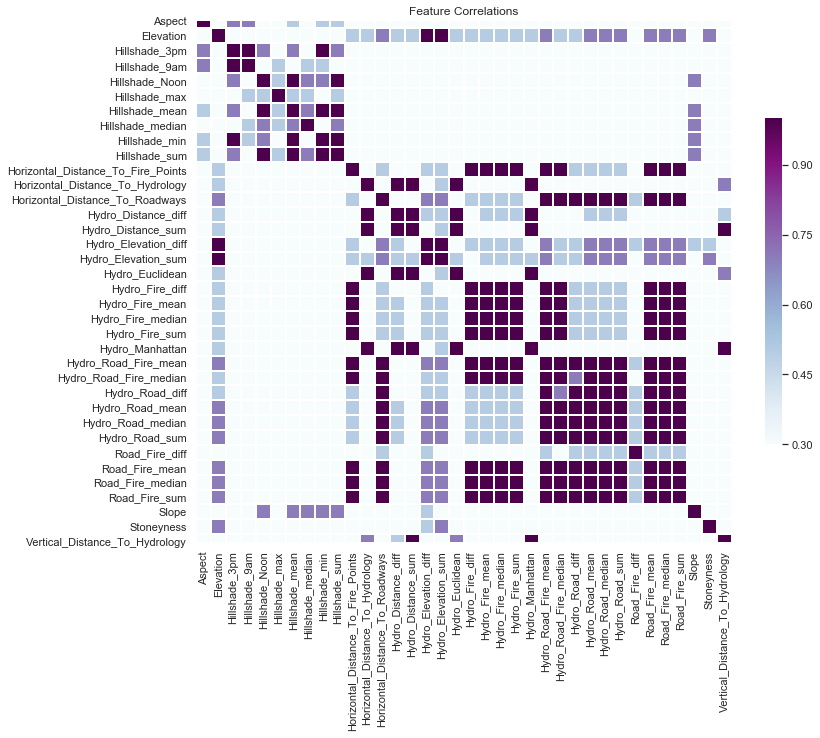

In [57]:
plot_correlations(X_train, annot=False)

In [58]:
# Drop umportant columns from test data
test = test.drop(unimportant_cols, axis='columns')

In [64]:
test.shape,X_train.shape

((565892, 46), (15120, 46))

In [60]:
# Function to drop the correlated features in the dataset X_
def drop_correlated(X_):
    X = X_.copy()
    
    drop_cols = ['Hillshade_mean', 'Hillshade_median', 'Hillshade_max', 
                 'Hillshade_min', 'Hillshade_sum', 'Hydro_Elevation_sum',
                 'Hydro_Distance_sum', 'Hydro_Distance_diff', 'Hydro_Fire_mean', 
                 'Hydro_Fire_median', 'Hydro_Manhattan', 'Hydro_Road_Fire_mean', 
                 'Hydro_Road_Fire_median', 'Hydro_Road_mean', 'Hydro_Road_median', 
                 'Road_Fire_mean', 'Road_Fire_median']
    
    drop_cols = [col for col in drop_cols if col in X.columns]
    
    X = X.drop(drop_cols, axis='columns')
    
    return drop_cols,X

In [61]:
# Drop the correlated features
dropped_cols, X_train = drop_correlated(X_train)

Show the evaluation metrics on our new group of features

Cross-validation accuracy: 0.814 [0.802 0.78  0.793 0.816 0.88 ]


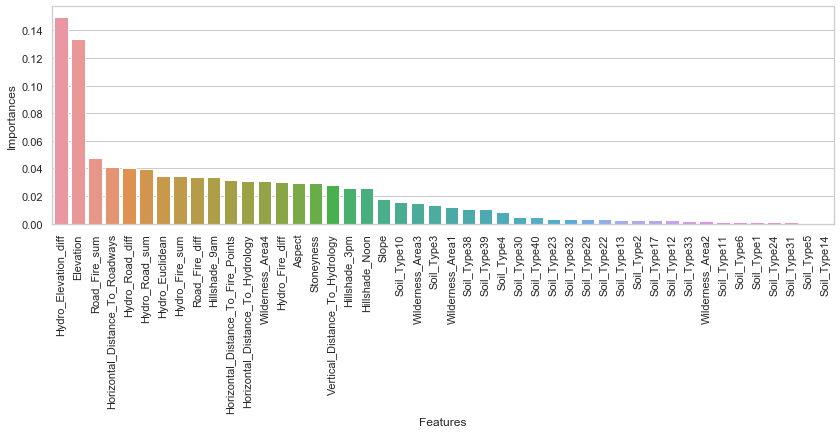

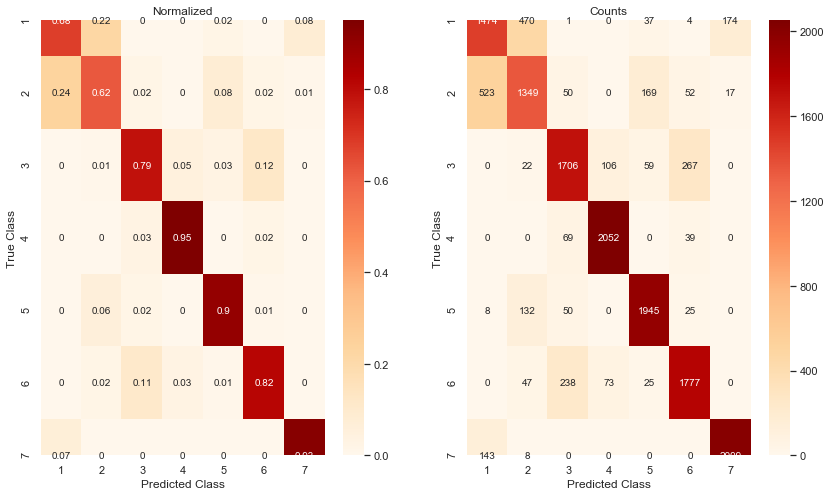

In [62]:
cv_accuracy(clf, X_train, y_train)
feature_importances(clf, X_train, y_train)
cv_confusion(clf, X_train, y_train)

In [63]:
#Drop correlated columns from test data
test = test.drop(dropped_cols, axis='columns')

### Save the resulting dataset to reuse in future tasks

In [65]:
# Include the label variable to the dataset
df1 = X_train.assign(Cover_Type=y_train)
# Save the train dataframe to a csv file
df1.to_csv(train_path+'\\train_fe.csv', sep=',', header=True, index=True, index_label='Id')
# Save the test dataframe to a csv file
test.to_csv(test_path+'\\test_fe.csv', sep=',', header=True, index=True, index_label='Id')